# Chapter 10

## Preamble

In [6]:
import numpy as np
import pandas as pd
import pymc3 as pm
from pymc3.glm import GLM
import arviz as az
import rethinking
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import theano

## Exercises 10E1-10E4

In [2]:
# 10E1
np.log(0.35 / (1 - 0.35))

-0.6190392084062235

In [3]:
# 10E2
np.exp(3.2) / (1 + np.exp(3.2))

0.9608342772032357

In [4]:
# 10E3
# log p / (1 - p) = 1.7, thus odds are multiplied by e^1.7
np.exp(1.7)

5.4739473917272

In [5]:
# 10E4
# To account for differences in the unit of the rate parameter

## Exercises 10M1-10M6

In [6]:
# 10M1
# For disaggregated form the likelihood takes into account the order in which the trails were run,
# while in aggregated form it doesn't.

In [ ]:
# 10M2
# The rate for the resulting Poisson model is multiplied by (e^1.7)^x. This means that the
# expected number of arrivals in a unit interval is multiplied by that number.

In [11]:
# 10M3
# The probability needs to be in between 0 and 1. Increasing the linear term for an already high probability
# should give rise to a smaller change in probability than when the linear term is average.

In [ ]:
# 10M4
# The rate is unbounded.

In [ ]:
# 10M5
# This would mean the rate is between 0 and 1, or by scaling, bounded. A research problem in which
# there is a priori information about the rate.

In [ ]:
# 10M6
# Fixed mean and a bounded number of successes, fixed mean an un unbounded number of
# successes. The constraints are the same, one is a limit of the other.

## Exercises 10H1-10H2

### Construct models

In [52]:
df = pd.read_csv("../external/rethinking/data/chimpanzees.csv", sep=";")
print(f"Number of rows {len(df)}")
display(df.head())

Number of rows 504


,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,1,NaN,0,1,2,0,1,0
1,1,NaN,0,1,4,0,0,1
2,1,NaN,0,1,6,1,0,0
3,1,NaN,0,1,8,0,1,0
4,1,NaN,0,1,10,1,1,1


In [68]:
x1 = df["prosoc_left"].values
x2 = df["condition"].values
observed = df["pulled_left"].values
models = []
    
with pm.Model() as model:
    α = pm.Normal("α", 0, 10)
    odds = α
    y = pm.Bernoulli("y", 1 / (1 + pm.math.exp(-odds)), observed=observed)
models.append(model)
    
with pm.Model() as model:
    α = pm.Normal("α", 0, 10)
    β1 = pm.Normal("β1", 0, 10)
    odds = α + β1 * x1
    y = pm.Bernoulli("y", 1 / (1 + pm.math.exp(-odds)), observed=observed)
models.append(model)
    
with pm.Model() as model:
    α = pm.Normal("α", 0, 10)
    β1 = pm.Normal("β1", 0.6, 10)
    β12 = pm.Normal("β12", -0.1, 10)
    odds = α + β1 * x1 + β12 * x1 * x2
    y = pm.Bernoulli("y", 1 / (1 + pm.math.exp(-odds)), observed=observed)
models.append(model) 

idx = df["actor"].values - 1
n_actors = len(set(idx))
with pm.Model() as model4:
    α = pm.Normal("α", 0.05, 10, shape=(n_actors,))
    β1 = pm.Normal("β1", 0.6, 10)
    β12 = pm.Normal("β12", -0.1, 10)
    odds = α[idx] + β1 * x1 + β12 * x1 * x2
    y = pm.Bernoulli("y", 1 / (1 + pm.math.exp(-odds)), observed=observed)
models.append(model4)

In [71]:
traces = []
kwargs = {"draws": 1000, "target_accept": 0.9}
for m in models:
    traces.append(pm.sample(model=m, start=pm.find_MAP(model=m), **kwargs))

logp = -352.57, ||grad|| = 40: 100%|██████████| 6/6 [00:00<00:00, 3370.72it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:01<00:00, 5236.55draws/s]
logp = -355.79, ||grad|| = 54.489: 100%|██████████| 8/8 [00:00<00:00, 2320.18it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β1, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:02<00:00, 2799.79draws/s]
logp = -347.99, ||grad|| = 7.1745: 100%|██████████| 10/10 [00:00<00:00, 2771.08it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β12, β1, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:03<00:00, 1884.16draws/s]
logp = -285.83, ||grad|| = 0.00076649: 100%|██████████| 23/23 [00:00<00:00, 2444

### Intermezzo: Comparing the third and fourth models

In [115]:
display(az.summary(traces[2]))
display(az.summary(traces[3]))

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,0.044,0.127,-0.204,0.265,0.003,0.002,2066.0,1961.0,2069.0,2150.0,1.0
β1,0.620,0.228,0.212,1.052,0.005,0.004,1766.0,1734.0,1777.0,2043.0,1.0
β12,-0.103,0.263,-0.596,0.388,0.006,0.004,1967.0,1751.0,1972.0,1734.0,1.0


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α[0],-0.740,0.279,-1.262,-0.226,0.004,0.003,4144.0,3697.0,4165.0,2909.0,1.0
α[1],11.031,5.377,3.489,21.305,0.139,0.109,1500.0,1215.0,2041.0,1502.0,1.0
α[2],-1.052,0.278,-1.558,-0.527,0.005,0.004,3111.0,2928.0,3144.0,2859.0,1.0
α[3],-1.049,0.281,-1.587,-0.530,0.005,0.003,3467.0,3330.0,3475.0,2857.0,1.0
α[4],-0.745,0.278,-1.277,-0.235,0.005,0.003,3678.0,3256.0,3693.0,2632.0,1.0
α[5],0.221,0.267,-0.273,0.726,0.005,0.004,3398.0,2500.0,3403.0,2770.0,1.0
α[6],1.819,0.396,1.056,2.535,0.006,0.005,4058.0,3505.0,4176.0,2438.0,1.0
β1,0.836,0.261,0.353,1.318,0.005,0.004,2383.0,2322.0,2375.0,2433.0,1.0
β12,-0.134,0.298,-0.712,0.407,0.005,0.005,3447.0,2057.0,3452.0,2533.0,1.0


### Intermezzo: What happens when we only single out the second actor?

In [127]:
is_second_actor = np.where(df["actor"] == 2, 1, 0)
with pm.Model() as model:
    α = pm.Normal("α", 0.05, 10, shape=(2,))
    β1 = pm.Normal("β1", 0.6, 10)
    β12 = pm.Normal("β12", -0.1, 10)
    odds = α[is_second_actor] + β1 * x1 + β12 * x1 * x2
    y = pm.Bernoulli("y", 1 / (1 + pm.math.exp(-odds)), observed=observed)
if len(models) > 4:
    models[4] = model
else:
    models.append(model)

In [128]:
trace = pm.sample(model=models[4], start=pm.find_MAP(model=models[4]), **kwargs)
if len(traces) > 4:
    traces[4] = trace
else:
    traces.append(trace)

logp = -307.11, ||grad|| = 0.28296: 100%|██████████| 21/21 [00:00<00:00, 2096.90it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β12, β1, α]
Sampling 4 chains, 3 divergences: 100%|██████████| 6000/6000 [00:04<00:00, 1213.29draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [129]:
display(az.summary(traces[4]))
rethinking.compare({f"model{i + 1}": t for (i, t) in enumerate(traces)})

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α[0],-0.286,0.139,-0.537,-0.027,0.003,0.002,1697.0,1565.0,1722.0,2126.0,1.0
α[1],11.028,5.421,3.152,20.644,0.160,0.120,1152.0,1024.0,1448.0,1347.0,1.0
β1,0.708,0.238,0.268,1.163,0.006,0.004,1605.0,1549.0,1607.0,2113.0,1.0
β12,-0.122,0.284,-0.625,0.421,0.007,0.005,1760.0,1585.0,1758.0,2066.0,1.0


,waic,p_waic,dwaic,weights
model4,-264.954098,8.347510,0.000000,9.999999e-01
model5,-297.159535,3.142405,32.205437,1.015496e-07
model2,-340.319445,2.070738,75.365347,4.311444e-17
model3,-341.195878,3.025594,76.241780,2.781684e-17
model1,-343.974439,1.003762,79.020341,6.933475e-18


### Exercise 10H1

logp = -285.83, ||grad|| = 0.00076649: 100%|██████████| 23/23 [00:00<00:00, 2617.31it/s]  


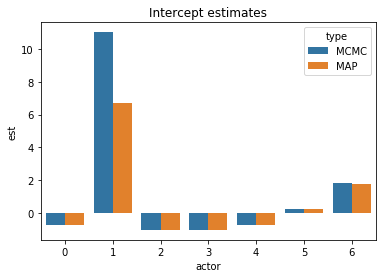

In [114]:
estimate = pm.find_MAP(model=models[3])

MCMC = pd.DataFrame()
MCMC["actor"] = list(range(n_actors))
MCMC["est"] = np.mean(traces[3]["α"], axis=0)
MCMC["type"] = "MCMC"

MAP = pd.DataFrame()
MAP["actor"] = list(range(n_actors))
MAP["est"] = estimate["α"]
MAP["type"] = "MAP"

data = pd.concat([MCMC, MAP], ignore_index=True)

sns.barplot(x="actor", y="est", hue="type", data=data);
plt.title("Intercept estimates");

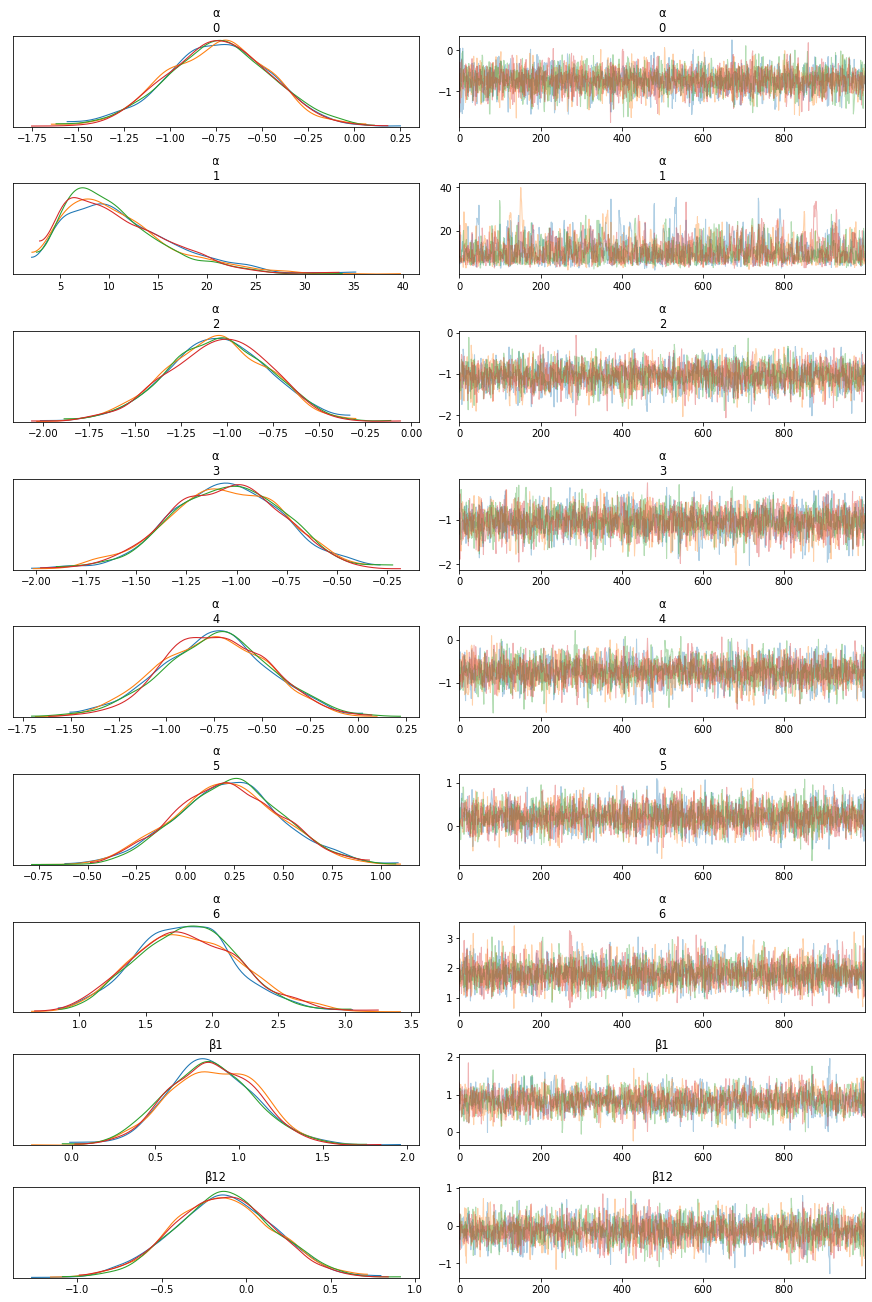

In [112]:
az.plot_trace(traces[3]);

In [ ]:
# Answer: The distribution of α1 (the second actor) is heavily skewed. Hence, a MAP estimate
# does not equal the sample mean of the MCMC samples. The reason for the skewedness is that
# the second actor always pulls the left lever, so any value for the intercept matches
# reality as long as it is high enough.
# The other estimates are very similar, that is to be expected from the shape of the
# posterior distributions, which are roughly Gaussian, or at least non-skewed.

### Exercise 10H2

In [75]:
rethinking.compare({f"model{i + 1}": t for (i, t) in enumerate(traces)})

,waic,p_waic,dwaic,weights
model4,-264.954098,8.347510,0.000000,1.000000e+00
model2,-340.319445,2.070738,75.365347,4.311444e-17
model3,-341.195878,3.025594,76.241780,2.781684e-17
model1,-343.974439,1.003762,79.020341,6.933476e-18


## Exercise 10H4 (discuss)

### Construct and compare models

In [8]:
df = pd.read_csv("../external/rethinking/data/salamanders.csv", sep=";")
print(f"Number of rows {len(df)}")
display(df.head())

Number of rows 47


,SITE,SALAMAN,PCTCOVER,FORESTAGE
0,1,13,85,316
1,2,11,86,88
2,3,11,90,548
3,4,9,88,64
4,5,8,89,43


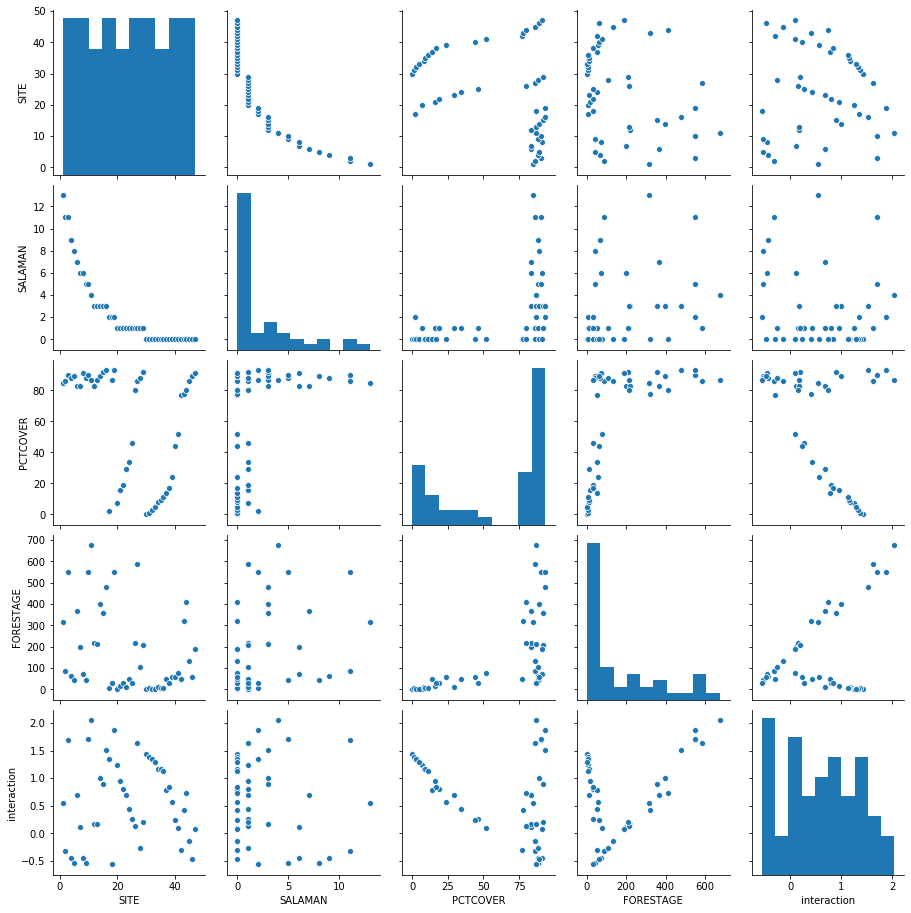

In [9]:
forestage = (df["FORESTAGE"] - df["FORESTAGE"].mean()) / df["FORESTAGE"].std()
pctcover = (df["PCTCOVER"] - df["PCTCOVER"].mean()) / df["PCTCOVER"].std()
df["interaction"] = forestage * pctcover 
sns.pairplot(df);

In [42]:
cover = df["PCTCOVER"].values / 100
x1 = theano.shared(cover) 
x2 = df["FORESTAGE"].values
x12 = df["interaction"].values
observed = df["SALAMAN"].values

models = []
with pm.Model() as model:
    α = pm.Normal("α", 0, 100)
    β1 = pm.Normal("β1", 0, 1)
    rate = pm.math.exp(α + β1 * x1)
    y = pm.Poisson("y", mu=rate, observed=observed)
models.append(model)

with pm.Model() as model:
    α = pm.Normal("α", 0, 10)
    β1 = pm.Normal("β1", 0, 10)
    β2 = pm.Normal("β2", 0, 10)
    rate = pm.math.exp(α + β1 * x1 + β2 * x2)
    y = pm.Poisson("y", mu=rate, observed=observed)
models.append(model)

with pm.Model() as model:
    α = pm.Normal("α", 0, 10)
    β1 = pm.Normal("β1", 0, 10)
    β12 = pm.Normal("β12", 0, 10)
    rate = pm.math.exp(α + β1 * x1 + β12 * x12)
    y = pm.Poisson("y", mu=rate, observed=observed)
models.append(model)

In [43]:
traces = []
kwargs = {"draws": 4000, "target_accept": 0.9, "tune": 1000}
for m in models:
    traces.append(pm.sample(model=m, start=pm.find_MAP(model=m), **kwargs))

logp = -113.81, ||grad|| = 1.0005e-06: 100%|██████████| 12/12 [00:00<00:00, 3604.90it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β1, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 20000/20000 [00:06<00:00, 2957.15draws/s]
The number of effective samples is smaller than 25% for some parameters.
logp = -113.09, ||grad|| = 1,612.8: 100%|██████████| 48/48 [00:00<00:00, 4005.70it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β2, β1, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 20000/20000 [00:14<00:00, 1396.96draws/s]
logp = -112.91, ||grad|| = 0.035106: 100%|██████████| 14/14 [00:00<00:00, 3320.15it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β12, β1, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 20000/20000 [0

In [44]:
for t in traces:
    display(az.summary(t))

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,-0.999,0.355,-1.643,-0.336,0.006,0.004,3489.0,3323.0,3493.0,3521.0,1.0
β1,2.640,0.424,1.843,3.419,0.007,0.005,3467.0,3419.0,3476.0,3570.0,1.0


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,-1.568,0.465,-2.444,-0.708,0.007,0.005,4552.0,4248.0,4658.0,4787.0,1.0
β1,3.341,0.580,2.277,4.431,0.009,0.006,4513.0,4335.0,4598.0,4609.0,1.0
β2,-0.000,0.001,-0.001,0.001,0.000,0.000,6620.0,5233.0,6612.0,6717.0,1.0


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,-1.539,0.476,-2.433,-0.667,0.007,0.005,4902.0,4566.0,5020.0,5541.0,1.0
β1,3.298,0.557,2.285,4.352,0.008,0.006,4992.0,4807.0,5084.0,5433.0,1.0
β12,-0.003,0.114,-0.216,0.209,0.001,0.001,6753.0,5090.0,6758.0,6704.0,1.0


In [46]:
xs = np.linspace(0, 1)
x1.set_value(xs)
post_pred = pm.sample_ppc(traces[0], samples=10000, model=models[0])
x1.set_value(cover)

<ipython-input-46-60ff410c41b8>:3: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  post_pred = pm.sample_ppc(traces[0], samples=10000, model=models[0])
100%|██████████| 10000/10000 [00:09<00:00, 1017.65it/s]


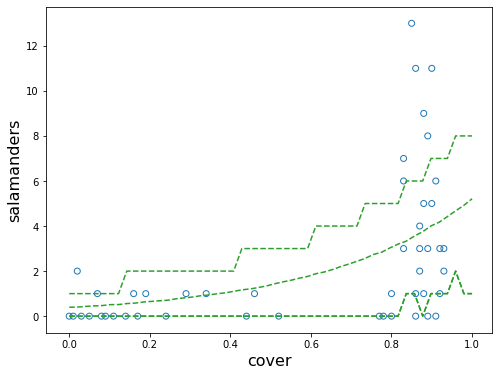

In [47]:
plt.figure(figsize=(8, 6))

plt.plot(xs, post_pred['y'].mean(0), ls='--', color='C2')
hpd_post_pred = pm.hpd(post_pred['y'], credible_interval=0.89)

plt.plot(xs, hpd_post_pred[:,0], ls='--', color='C2')
plt.plot(xs, hpd_post_pred[:,], ls='--', color='C2')

plt.scatter(cover, observed, facecolor='None', edgecolors='C0')
plt.xlabel('cover', fontsize=16)
plt.ylabel('salamanders', fontsize=16);

In [48]:
rethinking.compare({f"model{i+1}": t for (i, t) in enumerate(traces)})

/home/bart/.pyenv/versions/anaconda3-5.3.1/envs/statistical-rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:1208: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,waic,p_waic,dwaic,weights
model1,-107.157178,4.452177,0.000000,0.538078
model2,-108.814981,7.610969,1.657804,0.234886
model3,-108.882969,7.651233,1.725791,0.227036
